# Regression Modeling to Predict Loyalty Scores
In this project, we apply regression modeling to predict the loyalty scores for customers missing loyalty scores.
Only 50% of the customer data contains loyalty information, which we will use to predict the loyalty scores of
the remaining customers. 
_________

## Table of Contents
- Data Overview
- Data Preparation
- Modeling Overview
- Applying Linear Regression Modeling
- Applying Decision Tree Modeling
- Applying Random Forest Modeling
- Analyzing the Results
_________

## Date Overview
We will be predicting the *loyalty_score* metric.  This metric exists (for half of the customer base) in the *loyalty_scores* table of the client database.

The key variables hypothesised to predict the missing loyalty scores will come from the client database, namely the *transactions* table, the *customer_details* table, and the *product_areas* table.

Using pandas in Python, we merged these tables together for all customers, creating a single dataset that we can use for modelling.

In [1]:
# import libraries
import pandas as pd
import pickle

In [2]:
# import data
loyalty_scores = pd.read_excel("data/grocery_database.xlsx", sheet_name = 'loyalty_scores')
customer_details = pd.read_excel("data/grocery_database.xlsx", sheet_name = 'customer_details')
transactions = pd.read_excel("data/grocery_database.xlsx", sheet_name = 'transactions')

# merge loyalty score data and customer details data, at customer level
data_for_regression = pd.merge(customer_details, loyalty_scores, how = "left", on = "customer_id")

data_for_regression.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score
0,74,3.38,F,0.59,0.263
1,524,4.76,F,0.52,0.298
2,607,4.45,F,0.49,0.337
3,343,0.91,M,0.54,0.873
4,322,3.02,F,0.63,0.350


In [3]:
# aggregate sales data from transactions table
sales_summary = transactions.groupby('customer_id').agg({
    'sales_cost': 'sum',
    'num_items': 'sum',
    'transaction_id': 'count',
    'product_area_id': 'nunique'
}).reset_index()

sales_summary.head()

,customer_id,sales_cost,num_items,transaction_id,product_area_id
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


## Data Preparation

In [4]:
# rename columns for clarity
sales_summary.columns = [
    'customer_id',
    'total_sales',
    'total_items',
    'transaction_count',
    'product_area_count'
]

# engineer an average basket value for each customer
sales_summary['average_basket_value'] = sales_summary['total_sales'] / sales_summary['transaction_count']

# merge the sales summary with overall customer data
data_for_regression = pd.merge(data_for_regression, sales_summary, how = 'inner', on = 'customer_id')

data_for_regression.head(n = 5)

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [5]:
# split out data for modeling (loyalty score present)
regression_modeling = data_for_regression.loc[data_for_regression['customer_loyalty_score'].notna()]

# split out data for scoring post-modelling (loyalty score is missing)
# drop the loyalty score column (as it is blank/redundant)
regression_scoring = data_for_regression.loc[data_for_regression['customer_loyalty_score'].isna()]
regression_scoring = regression_scoring.drop(["customer_loyalty_score"], axis = 1)

In [6]:
# save our datasets for future use
pickle.dump(regression_modeling, open("data/customer_loyalty_modelling.p", "wb"))
pickle.dump(regression_scoring, open("data/customer_loyalty_scoring.p", "wb"))

In [7]:
# display regression modeling data
regression_modeling.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [8]:
# display regression scoring data
regression_scoring.head()

,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,3448.59,370,49,5,70.379388


## Modeling Overview
We will build a model that looks to accurately predict the “loyalty_score” metric for those customers that were able to be tagged, based upon the customer metrics listed above.

If that can be achieved, we can use this model to predict the customer loyalty score for the customers that were unable to be tagged by the agency.

As we are predicting a numeric output, we tested three regression modelling approaches;
- Linear Regression
- Decision Tree
- Random Forest

## Linear Regression
We utlise the scikit-learn library within Python to model our data using Linear Regression. The code sections below are broken up into 4 key sections:

- Data Import
- Data Preprocessing
- Model Training
- Performance Assessment

In [9]:
# import libraries
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [10]:
# import modelling data
data_for_model = pickle.load(open("data/customer_loyalty_modelling.p", "rb"))

# drop uneccessary columns
data_for_model = data_for_model.drop("customer_id", axis = 1)

# shuffle data
data_for_model = shuffle(data_for_model)

data_for_model.head()

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
35,44.37,F,0.55,0.268,2934.80,320,47,5,62.442553
261,1.85,F,0.50,0.444,1555.41,245,54,5,28.803889
51,0.87,M,0.60,0.851,1624.32,316,52,5,31.236923
226,1.85,M,0.63,0.242,1787.61,196,53,5,33.728491
798,5.88,F,0.60,0.511,9878.76,1148,101,5,97.809505


### Data Preprocessing
For Linear Regression we have certain data preprocessing steps that need to be addressed, including;
- Missing Values
- Outliers
- Encoding Categorical Variables
- Multicollinearity & Feature Selection

In [11]:
# deal with missing value
print(data_for_model.isna().sum())
data_for_model = data_for_model.dropna(how = 'any') # we don't need to use imputer in this case since we have a very small amount of na records

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64


In [13]:
# identify outliers (exploration)
description = data_for_model.describe()
description # distance_from_store, total_sales, and total_items seem to have extreme outliers

,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,2.021041,0.596117,0.509589,1846.502538,278.304569,44.926396,4.312183,36.781487
std,2.566045,0.101352,0.294504,1767.829482,214.236424,21.248012,0.725054,19.337336
min,0.000000,0.260000,0.002000,45.950000,10.000000,4.000000,2.000000,9.342000
25%,0.710000,0.530000,0.263000,942.067500,201.000000,41.000000,4.000000,22.406953
50%,1.645000,0.590000,0.510500,1471.490000,258.500000,50.000000,4.000000,30.365417
75%,2.910000,0.660000,0.771500,2104.727500,318.500000,53.000000,5.000000,47.208474
max,44.370000,0.880000,1.000000,9878.760000,1187.000000,109.000000,5.000000,102.335417


In [14]:
# deal with outliers using the boxplot approach
outlier_columns = [
    'distance_from_store', 
    'total_sales', 
    'total_items'
]

for col in outlier_columns:
    # calculate lower and upper quartiles
    lower_quartile = data_for_model[col].quantile(0.25)
    upper_quartile = data_for_model[col].quantile(0.75)

    # caluclate interquartile range
    iqr = upper_quartile - lower_quartile

    # calucalte extended interquartile range using a factor of 2
    iqr_extended = iqr * 2

    # calcualte max and min borders using extended iqr (these are the vertical ticks outside the boxplot)
    max_border = upper_quartile + iqr_extended
    min_border = lower_quartile - iqr_extended

    # return index value for outliers
    outliers = data_for_model[(data_for_model[col] < min_border) | (data_for_model[col] > max_border)].index 

    # print results
    print(f'Column [{col}]: Removed {len(outliers)} Outliers. \n \t Index: {outliers}')

    # remove outliers
    data_for_model = data_for_model.drop(outliers)

Column [distance_from_store]: Removed 2 Outliers. 
 	 Index: Int64Index([35, 733], dtype='int64')
Column [total_sales]: Removed 23 Outliers. 
 	 Index: Int64Index([798, 819, 794, 800, 806, 842, 784, 797, 811, 780, 808, 788, 786,
            782, 852, 809, 791, 789, 816, 790, 804, 793, 850],
           dtype='int64')
Column [total_items]: Removed 0 Outliers. 
 	 Index: Int64Index([], dtype='int64')


In [15]:
# split input and output variables
X = data_for_model.drop(['customer_loyalty_score'], axis = 1) # input vairables
y = data_for_model['customer_loyalty_score'] # output variable

In [16]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [17]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

Optimal Number of Features: 8 



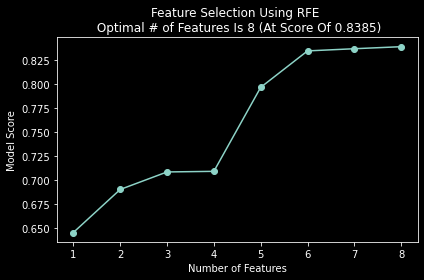

In [18]:
# feature selection

# instantiate regression and feature selecter object
regressor = LinearRegression()
feature_selector = RFECV(regressor)

# learn relationships
fit = feature_selector.fit(X_train, y_train)

# determine optimal number of features based on cross validation
optimal_feature_count = feature_selector.n_features_
print(f'Optimal Number of Features: {optimal_feature_count} \n')

# create new dataframe with selected features
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# plot results to visually determine best number of features
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection Using RFE \n Optimal # of Features Is {optimal_feature_count} (At Score Of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

In [19]:
# train model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [20]:
# predict on the test set
y_pred = regressor.predict(X_test)
y_pred

array([ 0.7617069 ,  0.69812018,  0.27449492,  0.41228465,  0.84462567,
        0.74868564,  0.65856876,  0.7346782 ,  0.52203485, -0.22188801,
        0.40027478,  0.39782248,  0.39417435,  0.27316588,  0.84854123,
        0.45815552,  0.25079775,  0.39027538,  0.62836119,  0.63025074,
        0.48557226,  0.78689992,  0.17620983,  0.72709312,  0.55210762,
        0.7395373 , -0.10097627,  0.29157941,  0.23301562,  0.78996555,
        0.36707331,  0.81148977,  0.80003702,  0.54588599,  0.75570752,
       -0.01570611,  0.28151832,  0.29513991,  0.98499373,  0.51793717,
        0.3337327 , -0.02064062,  0.16346084,  0.6692371 ,  0.17474042,
        0.67549318,  0.65397249, -0.07946931,  0.33190282,  0.70277176,
        0.24783439,  0.32058684,  0.46610453,  0.66247457,  0.2584008 ,
        0.15318585,  0.75913516,  0.61610281,  0.74841915,  0.39108525,
        0.54618463,  0.51441353,  0.89563315,  0.25357448,  0.50469263,
        0.71108096,  0.68341847, -0.0842004 , -0.04195549,  0.96

In [21]:
# calculate R-Squared
r_squared = r2_score(y_test, y_pred)
print(f'R-Squared = {r_squared}')

R-Squared = 0.8498188815541201


In [22]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
print(f'Cross Validation Score: {cv_scores.mean()}')

Cross Validation Score: 0.8364840798753876


In [23]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape # output of .shape is the number of rows and columns
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared}')

Adjusted R-Squared = 0.8313350515915503


In [24]:
# extract model coefficients
coefficients = pd.DataFrame(regressor.coef_)
input_var_names = pd.DataFrame(X_train.columns)
summary_coef = pd.concat([input_var_names, coefficients], axis = 1)
summary_coef.columns = ['input_variable', 'coefficient']

summary_coef

,input_variable,coefficient
0,distance_from_store,-0.186937
1,credit_score,-0.042236
2,total_sales,0.000104
3,total_items,0.001001
4,transaction_count,-0.003809
5,product_area_count,0.066520
6,average_basket_value,-0.002516
7,gender_M,0.026896


In [ ]:
# extract model intercept
intercept = regressor.intercept_
print(f'Intercept: {intercept}')

Intercept: 0.44431340247788736


The coefficient value for each of the input variables, along with that of the intercept would make up the equation for the line of best fit for this particular model (or more accurately, in this case it would be the plane of best fit, as we have multiple input variables).

For each input variable, the coefficient value we see above tells us, with *everything else staying constant* how many units the output variable (loyalty score) would change with a *one unit change* in this particular input variable.

## Decision Tree
We will again utlise the scikit-learn library within Python to model our data using a Decision Tree. The code sections below are broken up into 4 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment